In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

from glob import glob
from PIL import Image, ImageDraw, ImageFont

In [217]:
names = ['frame', 'id', 'x', 'y', 'w', 'h', 'dx', 'dy', 'dz']

In [218]:
path_MOT20 = '/media/mvlab/46FA9CA2FA9C8FB3/dataset/MOT/MOT20Det/MOT20Det/'

In [219]:
os.path.isdir(path_MOT20)

True

In [220]:
path_MOT20_train_01 = path_MOT20 + 'train/MOT20-01/'

In [221]:
os.path.isdir(path_MOT20_train_01)

True

In [222]:
path_MOT20_train_01_img = path_MOT20_train_01 + 'img1/'
path_MOT20_train_01_annot = path_MOT20_train_01 + 'gt/'
os.path.isdir(path_MOT20_train_01_img), os.path.isdir(path_MOT20_train_01_annot)

(True, True)

In [223]:
path_annotations = glob(path_MOT20_train_01_annot + '*')
print(len(path_annotations), path_annotations[0])
if len(path_annotations) > 0:
    path_annotation = path_annotations[0]
    print('path_annotation', path_annotation)

1 /media/mvlab/46FA9CA2FA9C8FB3/dataset/MOT/MOT20Det/MOT20Det/train/MOT20-01/gt/gt.txt
path_annotation /media/mvlab/46FA9CA2FA9C8FB3/dataset/MOT/MOT20Det/MOT20Det/train/MOT20-01/gt/gt.txt


In [224]:
path_images = glob(path_MOT20_train_01_img + '*')
path_images = np.sort(path_images)
len(path_images), path_images[0]

(429,
 '/media/mvlab/46FA9CA2FA9C8FB3/dataset/MOT/MOT20Det/MOT20Det/train/MOT20-01/img1/000001.jpg')

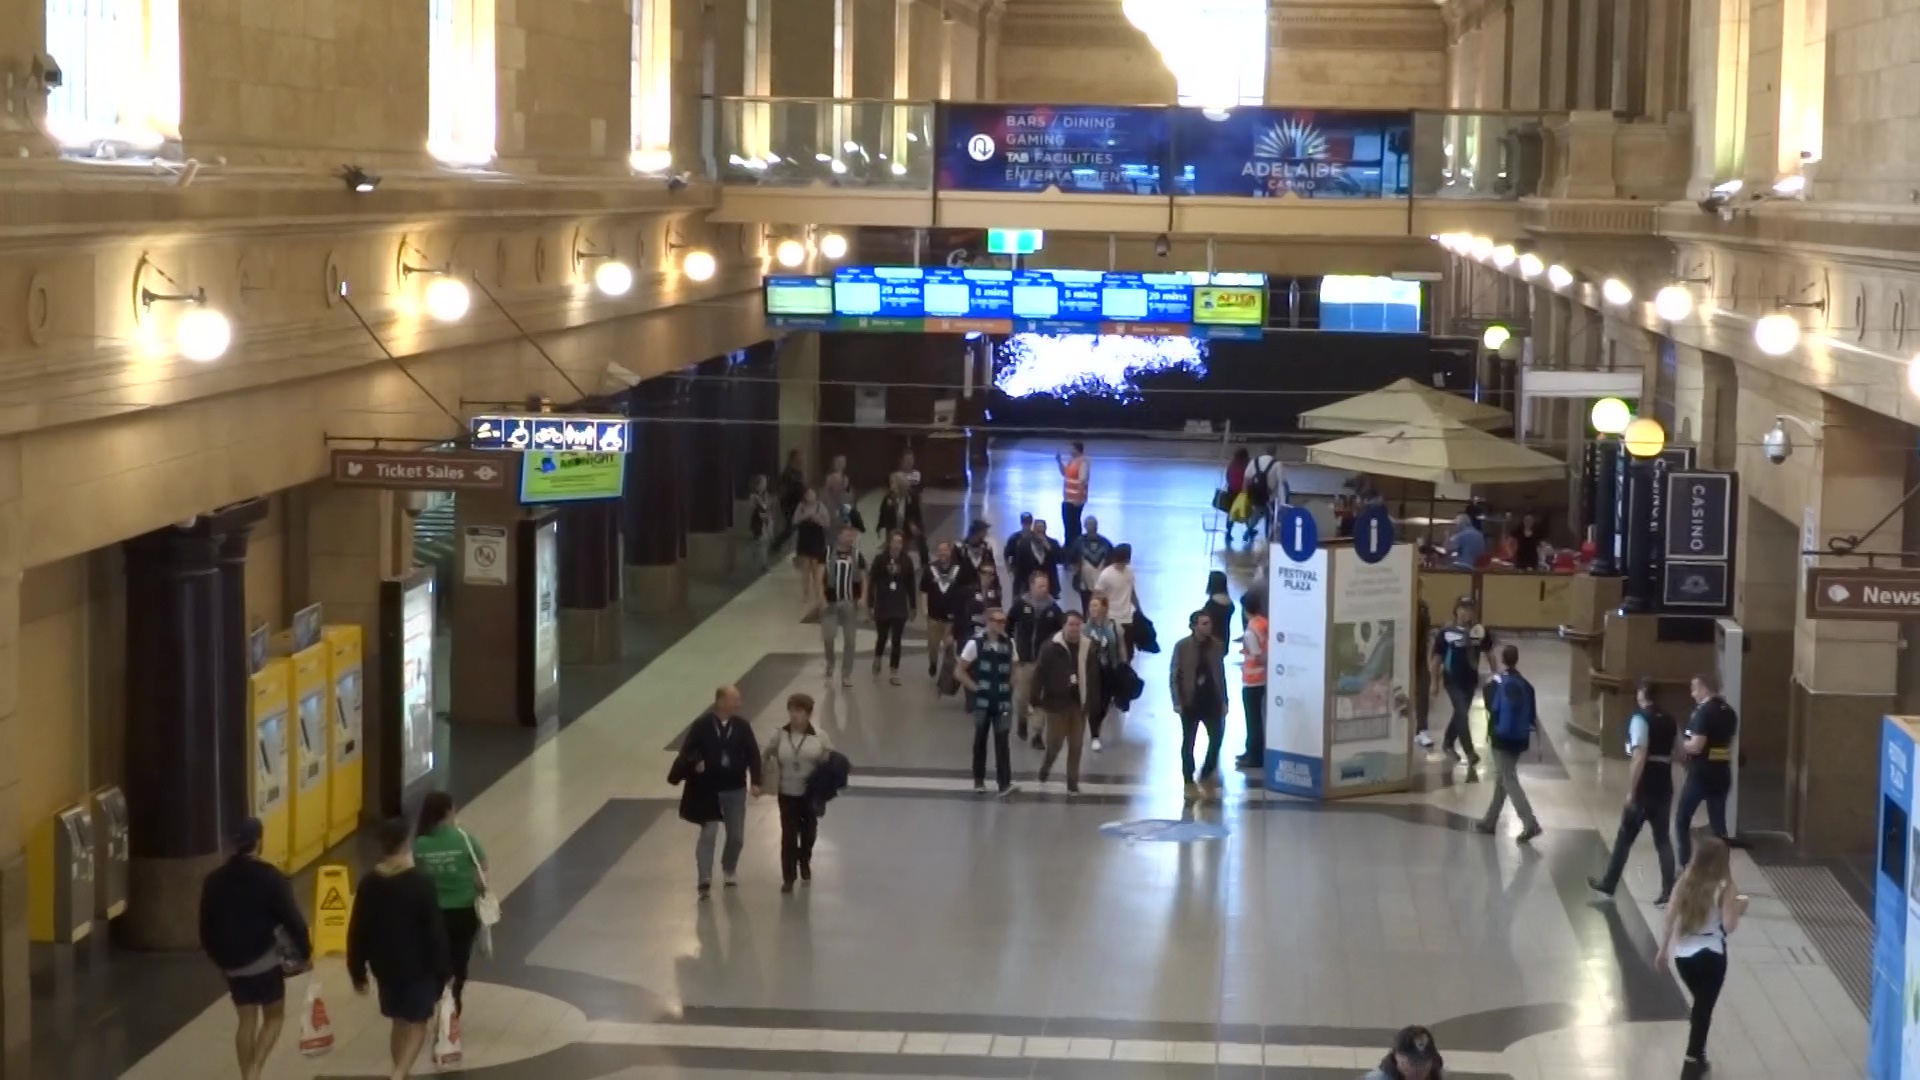

In [225]:
Image.open(path_images[0])

In [226]:
df = pd.read_csv(path_annotation, names=names)
df.shape

(26647, 9)

In [227]:
df.frame.nunique(), df.id.nunique()

(429, 90)

In [243]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1], display_1=False):
    
    image = np.array(image, dtype=np.uint8)    
    
    img_h, img_w, img_c = image.shape
    
    #image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        if display_1:
            if int(cls)!=1:
                continue
        x1, y1, w, h, id = box        
        #w, h = x2 - x1, y2 - y1
        color = [1,1,1]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 70:
            score_txt = str(cls)
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]
            label = sample_box[:, 0]
            bbox = sample_box[:, 1:]

            h, w, c = img_arr.shape
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

In [244]:
path_images[0]

'/media/mvlab/46FA9CA2FA9C8FB3/dataset/MOT/MOT20Det/MOT20Det/train/MOT20-01/img1/000001.jpg'

In [245]:
df.columns

Index(['frame', 'id', 'x', 'y', 'w', 'h', 'dx', 'dy', 'dz'], dtype='object')

In [250]:
df_f = df[df.frame==1]
box = df_f[['x', 'y', 'w', 'h', 'id']].values
dx = df_f['dx'].values
dy = df_f['dy'].values
#box

In [251]:
(dx==dy).mean()

0.6923076923076923

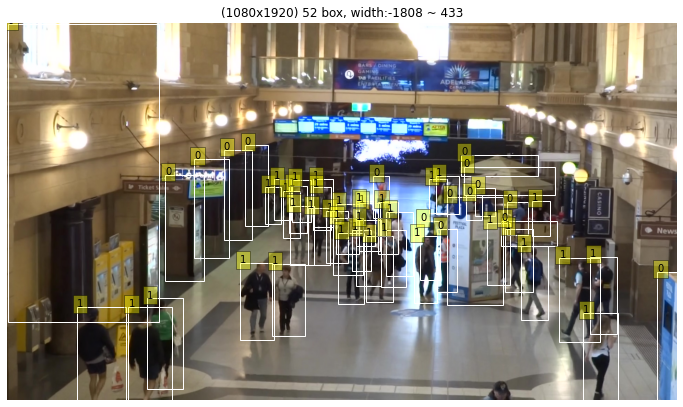

<AxesSubplot:title={'center':'(1080x1920) 52 box, width:-1808 ~ 433'}>

In [252]:
img_arr = np.array(Image.open(path_images[0]))
visualize_detections_simple(img_arr, box, dx, display_1=False)

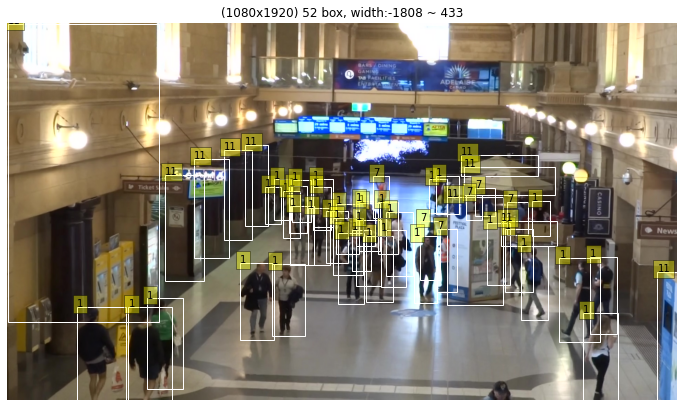

<AxesSubplot:title={'center':'(1080x1920) 52 box, width:-1808 ~ 433'}>

In [253]:
img_arr = np.array(Image.open(path_images[0]))
visualize_detections_simple(img_arr, box, dy, display_1=False)

In [254]:
list_y = []
list_path = []

def load_video(path_folder):
    print('path_folder', path_folder)
    
    path_img = path_folder + 'img1/'
    path_annot = path_folder + 'gt/'
    print('exist img', os.path.isdir(path_img), 'annot', os.path.isdir(path_annot))
    
    path_annotations = glob(path_annot + '*')
    print(len(path_annotations))
    if len(path_annotations) > 0:
        path_annotation = path_annotations[0]
        print('path_annotation', path_annotation)
        
        path_images = glob(path_img + '*')
        path_images = np.sort(path_images)
        print('image count', len(path_images))
        
        df = pd.read_csv(path_annotation, names=names)
        print('df', df.shape)
        
        cond = df.dy < 10
        df_valid = df[cond]
        print('df_valid', df_valid.shape)
        
        if len(path_images) != df.frame.nunique():
            print('[Warn] frame count not equal', len(path_images), df.frame.nunique())
            return 0
        else:            
            print('frame count equal', len(path_images), df.frame.nunique())
            
        for frame in np.sort(df_valid.frame.unique()):
            
            df_fr = df_valid[df.frame==frame]                    
            box = df_fr[['x', 'y', 'w', 'h', 'id']].values
            list_y.append(box)                        

    return path_images, list_y

In [255]:
path_images, list_y = load_video(path_MOT20_train_01)
len(path_images), len(list_y)


path_folder /media/mvlab/46FA9CA2FA9C8FB3/dataset/MOT/MOT20Det/MOT20Det/train/MOT20-01/
exist img True annot True
1
path_annotation /media/mvlab/46FA9CA2FA9C8FB3/dataset/MOT/MOT20Det/MOT20Det/train/MOT20-01/gt/gt.txt
image count 429
df (26647, 9)
df_valid (22444, 9)
frame count equal 429 429


<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame 

<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame 

<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]
<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame 

<ipython-input-254-5e34db29ae47>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df_valid[df.frame==frame]


(429, 429)

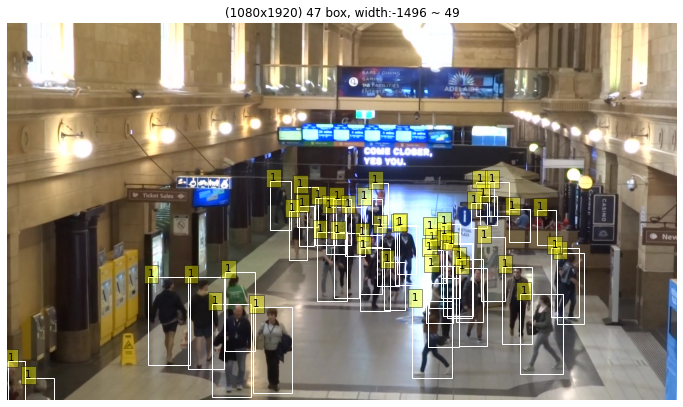

<AxesSubplot:title={'center':'(1080x1920) 47 box, width:-1496 ~ 49'}>

In [256]:
i = 100
class_dummy = np.ones_like(list_y[i][:, 0])
x = Image.open(path_images[i])
visualize_detections_simple(x, list_y[i], class_dummy)

429 0
429 10
429 20
429 30
429 40
429 50
429 60
429 70
429 80
429 90
429 100
429 110
429 120
429 130
429 140
429 150
429 160
429 170
429 180
429 190
429 200
429 210
429 220
429 230
429 240
429 250
429 260
429 270
429 280
429 290
429 300
429 310
429 320
429 330
429 340
429 350
429 360
429 370
429 380
429 390
429 400
429 410
429 420


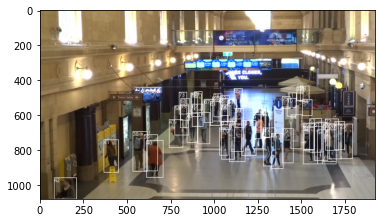

In [270]:
def save_image_with_gt(path_images, list_y, i, target_folder):    
    boxes = list_y[i]    
    im = Image.open(path_images[i])
    draw = ImageDraw.Draw(im)
    #font = ImageFont.load_default()
    font = ImageFont.truetype("NanumBarunGothic", 28)

    for box in boxes:
        x, y, w, h, iden = box        
        draw.rectangle([x, y, x+w, y+h], width=3)
        draw.text((x+1, y+1), str(iden), font=font)
        
    plt.imshow(im)
        
    if not os.path.isdir(target_folder):
        os.mkdir(target_folder)
    im.save(target_folder + str(i) + '.png')

target_folder = './0/'
for i in range(0, len(list_y)):
    if i%10==0:
        print(len(list_y), i)
        
    save_image_with_gt(path_images, list_y, i, target_folder)

In [271]:
size = Image.open(path_images[0]).size

In [273]:
glob

<function glob.glob(pathname, *, recursive=False)>

In [274]:
source_images = glob(target_folder + '*')
source_images = np.sort(source_images)
list_file_num = []
for path in source_images:
    file_name = path.split(os.sep)[-1]
    file_pre = file_name[:-4]
    list_file_num.append(int(file_pre))
    #print('file_pre', file_pre)

len(list_file_num)


429

In [275]:
source_images_sorted = np.array(source_images)[np.argsort(list_file_num)]
source_images_sorted

array(['./0/0.png', './0/1.png', './0/2.png', './0/3.png', './0/4.png',
       './0/5.png', './0/6.png', './0/7.png', './0/8.png', './0/9.png',
       './0/10.png', './0/11.png', './0/12.png', './0/13.png',
       './0/14.png', './0/15.png', './0/16.png', './0/17.png',
       './0/18.png', './0/19.png', './0/20.png', './0/21.png',
       './0/22.png', './0/23.png', './0/24.png', './0/25.png',
       './0/26.png', './0/27.png', './0/28.png', './0/29.png',
       './0/30.png', './0/31.png', './0/32.png', './0/33.png',
       './0/34.png', './0/35.png', './0/36.png', './0/37.png',
       './0/38.png', './0/39.png', './0/40.png', './0/41.png',
       './0/42.png', './0/43.png', './0/44.png', './0/45.png',
       './0/46.png', './0/47.png', './0/48.png', './0/49.png',
       './0/50.png', './0/51.png', './0/52.png', './0/53.png',
       './0/54.png', './0/55.png', './0/56.png', './0/57.png',
       './0/58.png', './0/59.png', './0/60.png', './0/61.png',
       './0/62.png', './0/63.png', '.

In [276]:
import cv2
import numpy as np
import glob
 
img_array = []
for filename in source_images_sorted:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('project30.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()